In [1]:
%matplotlib inline
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TEST_DATA_PROPORTION = 0.2

IMGS_PATH = 'D:/comma10k/imgs/'
MASKS_PATH = 'D:/comma10k/masks/'

# Goes through each file in a folder, ref: https://www.tutorialspoint.com/python/os_walk.htm
imgs_ids = next(os.walk(IMGS_PATH))[2]
masks_ids = next(os.walk(MASKS_PATH))[2]

# Training set
train_img = imgs_ids[round(TEST_DATA_PROPORTION*len(imgs_ids)):]
train_mask = masks_ids[round(TEST_DATA_PROPORTION*len(imgs_ids)):]

# Validation set
test_img = imgs_ids[:round(TEST_DATA_PROPORTION*len(imgs_ids))]
test_mask = masks_ids[:round(TEST_DATA_PROPORTION*len(imgs_ids))]

print(len(train_img))

7899


In [3]:
# Init training dataset
X_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_mask), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Resizing training images') 
for idx, path in tqdm(enumerate(train_img), total=len(train_img)):
    img = imread(IMGS_PATH + path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[idx] = img

  0%|                                                                                         | 0/7899 [00:00<?, ?it/s]

Resizing training images


100%|██████████████████████████████████████████████████████████████████████████████| 7899/7899 [26:09<00:00,  5.03it/s]


In [4]:
Y_train = np.zeros((len(train_mask), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for idx, path in tqdm(enumerate(train_mask), total=len(train_mask)): 
    mask = imread(MASKS_PATH + path)[:,:,:IMG_CHANNELS] 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #mask = np.maximum(mask, mask_)  
    Y_train[idx] = mask

100%|██████████████████████████████████████████████████████████████████████████████| 7899/7899 [21:19<00:00,  6.18it/s]


In [5]:
# Init test dataset
X_test = np.zeros((len(test_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#sizes_test = []

print('Resizing test images') 
for idx, path in tqdm(enumerate(test_img), total=len(test_img)):
    img = imread(IMGS_PATH + path)[:,:,:IMG_CHANNELS]
    #sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[idx] = img

  0%|                                                                                         | 0/1975 [00:00<?, ?it/s]

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████| 1975/1975 [06:39<00:00,  4.95it/s]


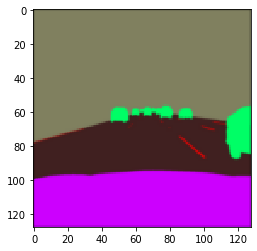

In [6]:
plt.imshow(Y_train[5])

In [7]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [8]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('segnet_model.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
  1/445 [..............................] - ETA: 0s - loss: 359.9568 - accuracy: 0.3517WARNING:tensorflow:From C:\Users\brand\miniconda3\envs\carnd\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
445/445 [==============================] - 69s 156ms/step - loss: 323.3924 - accuracy: 0.5290 - val_loss: 321.5441 - val_accuracy: 0.7194
Epoch 2/100
445/445 [==============================] - 24603s 55s/step - loss: 319.1623 - accuracy: 0.5529 - val_loss: 320.0372 - val_accuracy: 0.8124
Epoch 3/100
445/445 [==============================] - 103s 231ms/step - loss: 318.0084 - accuracy: 0.6344 - val_loss: 319.1468 - val_accuracy: 0.7596
Epoch 4/100
445/445 [==============================] - 117s 263ms/step - loss: 317.0023 - accuracy: 0.6585 - val_loss: 317.6246 - val_accuracy: 0.7459
Epoch 5/100
445/4

445/445 [==============================] - 68s 154ms/step - loss: 311.8785 - accuracy: 0.6892 - val_loss: 313.4906 - val_accuracy: 0.9444
Epoch 52/100
445/445 [==============================] - 71s 159ms/step - loss: 311.7262 - accuracy: 0.7008 - val_loss: 313.5653 - val_accuracy: 0.6383
Epoch 53/100
445/445 [==============================] - 71s 159ms/step - loss: 311.8944 - accuracy: 0.6755 - val_loss: 313.7209 - val_accuracy: 0.7988
Epoch 54/100
445/445 [==============================] - 70s 158ms/step - loss: 312.1177 - accuracy: 0.6998 - val_loss: 314.0088 - val_accuracy: 0.6219
Epoch 55/100
445/445 [==============================] - 70s 158ms/step - loss: 311.9597 - accuracy: 0.6937 - val_loss: 313.4676 - val_accuracy: 0.5090
Epoch 56/100
445/445 [==============================] - 70s 158ms/step - loss: 311.6776 - accuracy: 0.6885 - val_loss: 313.4342 - val_accuracy: 0.5538
Epoch 57/100
445/445 [==============================] - 71s 159ms/step - loss: 311.7722 - accuracy: 0.6894 

(7899, 128, 128, 3)
1/1 [==============================] - 0s 85ms/step


'\n \npreds_train_t = (preds_train > 0.5).astype(np.uint8)\npreds_val_t = (preds_val > 0.5).astype(np.uint8)\npreds_test_t = (preds_test > 0.5).astype(np.uint8)\n\n\n'

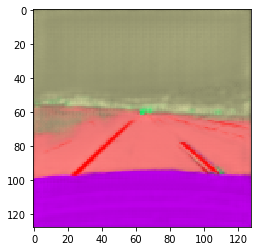

In [95]:
visual_range = 16
idx = random.randint(0, len(X_train[0:visual_range]))

print(X_train.shape)
#preds_train = model.predict(X_train[0:visual_range], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_train = model.predict(X_test[0:visual_range], verbose=1)

plt.imshow(preds_train[idx])

"""
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


"""


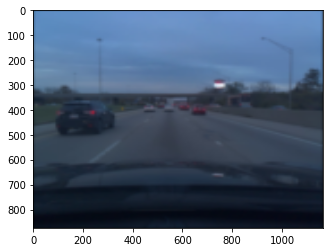

In [99]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train))
plt.imshow(resize(np.squeeze(X_train[ix]), (874,1164), mode='constant'))

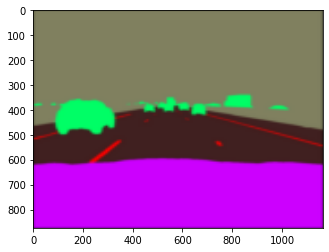

In [100]:
plt.imshow(resize(np.squeeze(Y_train[ix]), (874,1164), mode='constant'))

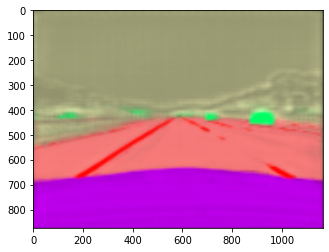

In [101]:
img = resize(preds_train[ix], (874,1164), mode='constant', preserve_range=True)
plt.imshow(img)

In [130]:
model.save("model.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


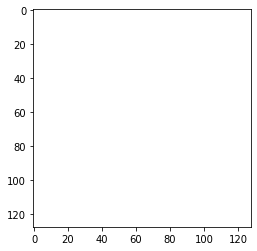

In [127]:
# Performing sanity check on file test data
test_img_path = "test_img4.jpg"
test = resize(imread(test_img_path), (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(test)

In [128]:
test_train = model.predict(test[np.newaxis, ...], verbose=1)

1/1 [==============================] - 0s 3ms/step


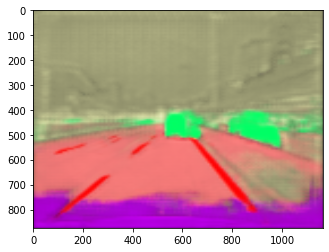

In [131]:
img = resize(test_train[0], (874,1164), mode='constant', preserve_range=True)
plt.imshow(img)

In [ ]:
path_to_video = "VIDEO_20200821_091431277.mp4"